In [464]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.ndimage import gaussian_laplace

In [465]:
def filtros(imagem):
  angulos = [0, 45, 90, 135]
  resultados = []

  for theta in angulos:
      filtro = cv2.getGaborKernel((21, 21), 4, np.deg2rad(theta), 10, 0.3)
      resultado = cv2.filter2D(imagem, cv2.CV_32F, filtro)
      resultados.append(resultado)

  resultado = gaussian_laplace(imagem, sigma=3)
  resultados.append(resultado)

  return resultados

In [466]:
def construir_stack_texturas(imagem):
    imagens = [imagem]
    img1 = cv2.resize(imagem, (256, 256))
    imagens.append(img1)
    img2 = cv2.resize(imagem, (128, 128))
    imagens.append(img2)

    stack_texturas = []
    for img in imagens:
        resultados = filtros(img)
        # Redimensiona os resultados para o tamanho original
        resultados_redimensionados = [cv2.resize(resultado, (512, 512)) for resultado in resultados]
        stack_texturas.extend(resultados_redimensionados)

    stack_texturas = np.stack(stack_texturas, axis=-1)
    return stack_texturas

In [467]:
def vetores_janela(stack_texturas, tamanho_janela):
    vetores = []
    coordenadas = []

    for i in range(0, 512, tamanho_janela):
        for j in range(0, 512, tamanho_janela):
            bloco = stack_texturas[i:i+tamanho_janela, j:j+tamanho_janela, :]
            media = bloco.mean(axis=(0, 1))
            vetores.append(media)
            coordenadas.append((i, j))

    return np.array(vetores), coordenadas

In [468]:
def segmentar_imagem(imagem, n_clusters, tamanho_janela):
    stack_texturas = construir_stack_texturas(imagem)
    vetores, posicoes = vetores_janela(stack_texturas, tamanho_janela)
    #agrupamento por kmeans
    kmeans = KMeans(n_clusters, random_state=0)
    labels = kmeans.fit_predict(vetores)
    #constroi a imagem segmentada
    img_segmentada = np.zeros((512, 512), dtype=np.uint8)
    for (i, j), label in zip(posicoes, labels):
        img_segmentada[i:i+tamanho_janela, j:j+tamanho_janela] = label

    return img_segmentada

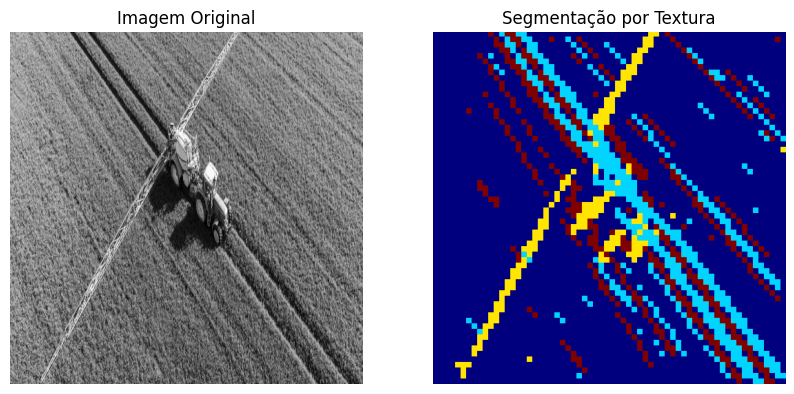

In [469]:
imagem = cv2.imread('img1.png', cv2.IMREAD_GRAYSCALE)
imagem = cv2.resize(imagem, (512, 512))

img_segmentada = segmentar_imagem(imagem, 4, 8)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(imagem, cmap='gray')
plt.title('Imagem Original')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img_segmentada, cmap='jet')
plt.title('Segmentação por Textura')
plt.axis('off')

plt.show()